#Importing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder

#Importing or Data Collection

In [ ]:
# Load the datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

In [ ]:
# Convert 'SignupDate' and 'TransactionDate' to datetime objects
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Feature Engineering

In [ ]:
customer_agg = transactions.groupby('CustomerID').agg({'TotalValue': 'sum', 'Quantity': 'sum'}).reset_index()
customers_df = pd.merge(customers, customer_agg, on='CustomerID', how='left')

In [ ]:
# Calculate Recency, Frequency, Monetary (RFM)
recent_date = transactions['TransactionDate'].max()
rfm = transactions.groupby('CustomerID').agg({
    'TransactionDate': lambda x: (recent_date - x.max()).days,
    'TransactionID': 'count',
    'TotalValue': 'sum'
}).rename(columns={'TransactionDate': 'Recency', 'TransactionID': 'Frequency', 'TotalValue': 'Monetary'})

In [ ]:
# Normalize RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])
rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm.index, columns=['Recency', 'Frequency', 'Monetary'])


In [ ]:
cluster_df=pd.merge(customers_df,rfm_scaled,on='CustomerID')
le = LabelEncoder()
cluster_df['Region'] = le.fit_transform(cluster_df['Region'])
cluster_df.sample(5)

,CustomerID,CustomerName,Region,SignupDate,TotalValue,Quantity,Recency,Frequency,Monetary
97,C0098,Laura Gilbert,2,2024-10-21,3158.02,14.0,-0.987630,1.356650,-0.169192
122,C0123,Jason Johnston,0,2023-11-05,1400.06,4.0,-0.422377,-1.379566,-1.130841
13,C0014,Deborah Wilcox,1,2024-06-22,318.66,2.0,3.831150,-1.835602,-1.722395
125,C0126,Caitlin Brown,3,2024-02-20,4565.57,13.0,-0.634347,0.444578,0.600774
25,C0026,Sara Miller,2,2024-05-03,3549.05,12.0,0.072219,-0.467494,0.044711


In [ ]:
# Select relevant features for clustering
features = ['Region', 'Recency', 'Frequency', 'Monetary']
X = cluster_df[features]

In [ ]:
# Determine optimal number of clusters (using the elbow method)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

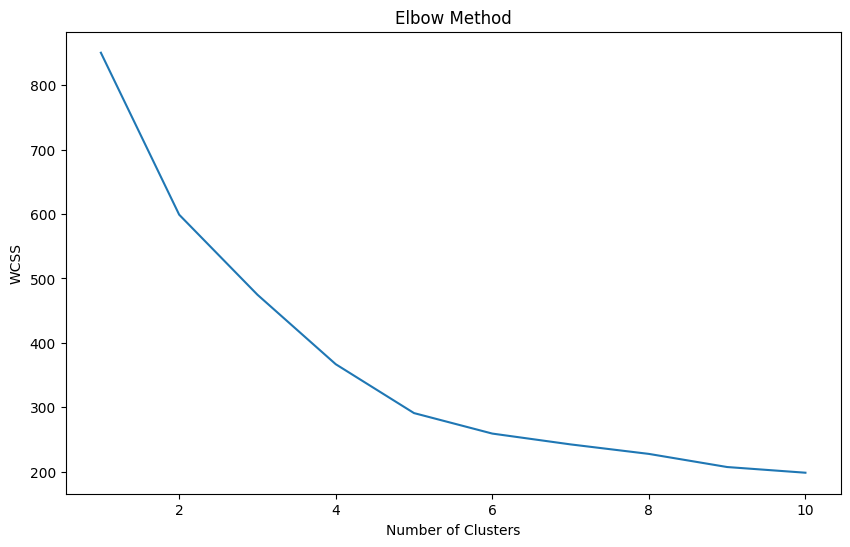

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.savefig('elbow_plot.png')  # Save the elbow plot

#Model Selection

In [ ]:
# Based on the elbow method, choose the optimal number of clusters
optimal_num_clusters = 9  # Example: Choose 3 clusters based on the elbow plot

# Create KMeans model with optimal number of clusters
kmeans = KMeans(n_clusters=optimal_num_clusters, init='k-means++', random_state=42)
kmeans.fit(X)

KMeans(n_clusters=9, random_state=42)

In [ ]:
# Predict cluster labels for each customer
cluster_df['Cluster'] = kmeans.labels_

In [ ]:
# Calculate DB Index
db_index = davies_bouldin_score(X, kmeans.labels_)
print(f'DB Index: {db_index}')

DB Index: 1.1471769354139907


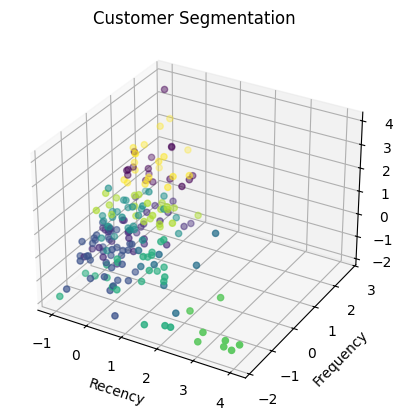

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X['Recency'], X['Frequency'], X['Monetary'], c=kmeans.labels_, cmap='viridis')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('Customer Segmentation')
plt.show()

In [ ]:
plt.savefig('customer_segmentation_3d.png')  # Save the 3D scatter plot

<Figure size 640x480 with 0 Axes>

In [ ]:
# Analyze cluster characteristics
cluster_analysis = cluster_df.groupby('Cluster').agg({
    'Region': pd.Series.mode,
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
})
print("\nCluster Profiling:")
print(cluster_analysis)


Cluster Profiling:
         Region   Recency  Frequency  Monetary
Cluster                                       
0             0 -0.441496   1.437127  1.428932
1             2 -0.257659   0.145304 -0.332206
2             0 -0.413975  -0.726325 -0.763869
3        [0, 1]  1.418227  -0.809521 -0.268864
4             3 -0.352177   0.165072  0.232542
5             3  0.606265  -0.980535 -0.878678
6        [0, 2]  3.310058  -1.664588 -1.411908
7             1  0.020190   0.320204  0.572167
8             3 -0.541787   1.447857  1.466991
